In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import optuna

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self,train_csv,val_csv,test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df, self.test_df

    def oversample_data_with_adasyn(self, train_df):
      if train_df is not None:
        X = train_df.drop(columns=['DiagPeriodL90D'], axis=1)
        y = train_df['DiagPeriodL90D']

        adasyn = ADASYN(random_state=37)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)

        train_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['DiagPeriodL90D'])], axis=1)

        return train_df

    def get_column_info(self):
        data_types = self.train_df.dtypes
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if "patient_zip3" in numerical_cols:
          numerical_cols.remove("patient_zip3")

        if "patient_zip3" not in categorical_cols:
          categorical_cols.append("patient_zip3")
        return categorical_cols, numerical_cols

    def impute_data(self):
      _, numerical_cols = self.get_column_info()

      excluded_cols = ['Unnamed: 0', 'DiagPeriodL90D']
      cols_to_impute = [col for col in numerical_cols if col not in excluded_cols]

      num_imputer = SimpleImputer(strategy='mean')

      if self.train_df is not None:
        self.train_df[cols_to_impute] = num_imputer.fit_transform(self.train_df[cols_to_impute])

      if self.val_df is not None:
        self.val_df[cols_to_impute] = num_imputer.transform(self.val_df[cols_to_impute])
      if self.test_df is not None:
        common_cols_to_impute = [col for col in cols_to_impute if col in self.test_df.columns]
        self.test_df[common_cols_to_impute] = num_imputer.transform(self.test_df[common_cols_to_impute])

      return self.train_df, self.val_df, self.test_df


    def select_top_features(self, df):
        selected_features = [
        "patient_id", "breast_cancer_diagnosis_code", "patient_age",
        "metastatic_cancer_diagnosis_code", "payer_type", "patient_race",
        "patient_zip3", "patient_state", "income_household_25_to_35",
        "rent_burden", "income_household_under_5","DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()

        if 'patient_zip3' in continuous_cols:
          continuous_cols.remove('patient_zip3')
        if 'patient_zip3' not in categorical_cols:
          categorical_cols.append('patient_zip3')

        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, test_df, continuous_columns, columns_to_exclude):
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])
        test_df[columns_to_scale] =  scaler.transform(test_df[columns_to_scale])

        return train_df, val_df, test_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        if train_columns is not None:
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        patient_id = df['patient_id'].values

        if target_column and target_column in df.columns:
          features = df.drop(columns=['patient_id', target_column])
          target = df[target_column]
        else:
          features = df.drop(columns=['patient_id'])
          target = None

        if target_column and target is not None:
          features, target = shuffle(features, target, random_state=42)

        return features, target, patient_id

train_val_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/imputed_values/'
test_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'


meta_obj = MetastaticDiagnosis()

train_csv = train_val_path + 'train_df.csv'
val_csv = train_val_path + 'val_df.csv'
test_csv = test_path + 'test.csv'

train_df, val_df, test_df = meta_obj.read_data(train_csv, val_csv, test_csv)



# missing_columns = set(val_df.columns) - set(train_df.columns)
# print("Column(s) missing in train_df:", missing_columns)

print("Train data shape :", train_df.shape, "\n")
print("Val data shape :", val_df.shape, "\n")

print("Test data shape:", test_df.shape, "\n")


train_df, val_df, test_df = meta_obj.impute_data()

missing_columns = set(val_df.columns) - set(train_df.columns)
print("Column(s) missing in train_df:", missing_columns)
val_df = val_df.drop(columns='predicted_patient_state')

# missing_columns = set(test_df.columns) - set(train_df.columns)
# print("Column(s) missing in train_df:", missing_columns)
# test_df = test_df.drop(columns='predicted_patient_state')


print("Train data shape after imputation:", train_df.shape)
print("Validation data shape after imputation:", val_df.shape, "\n")
print("Test data shape after imputation:", test_df.shape, "\n")


train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")

train_df = train_df.drop('Unnamed: 0', axis=1)
val_df = val_df.drop('Unnamed: 0', axis=1)
#test_df = test_df.drop('Unnamed: 0', axis=1)

continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")

continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled, test_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected,test_df, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape)
print("After scaling test data", test_df_scaled.shape, "\n")


train_df_encoded = meta_obj.preprocess_data(train_df_scaled, None, category_cols)

train_columns = train_df_encoded.columns.tolist()

val_df_encoded = meta_obj.preprocess_data(val_df_scaled, train_columns, category_cols)

test_df_encoded = meta_obj.preprocess_data(test_df_scaled, train_columns, category_cols)



print("Train data shape after one hot encoding: ", train_df_encoded.shape)
print("Validation data shape after one hot encoding: ", val_df_encoded.shape, "\n")
print("test_df_encoded data shape after one hot encoding: ", test_df_encoded.shape, "\n")


# Call the oversample_data function
train_df_encoded = meta_obj.oversample_data_with_adasyn(train_df_encoded)
print("Train data shape after oversampling columns:", train_df_encoded.shape, "\n")


X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_encoded, 'DiagPeriodL90D', is_fit=True)

X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_encoded, 'DiagPeriodL90D', is_fit=False)

X_test, _, test_patient_id = meta_obj.preprocess_and_shuffle(test_df_encoded, target_column=None, is_fit=False)


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")



if 'DiagPeriodL90D' in X_test.columns:
    X_test = X_test.drop(columns=['DiagPeriodL90D'])

extra_columns = set(X_test.columns) - set(X_train.columns)
print(f"Extra columns in X_test: {extra_columns}")
print("X_test shape: ", X_test.shape, "\n")


Train data shape : (10324, 82) 

Val data shape : (2582, 83) 

Test data shape: (5792, 82) 

Column(s) missing in train_df: {'predicted_patient_state'}
Train data shape after imputation: (10324, 82)
Validation data shape after imputation: (2582, 82) 

Test data shape after imputation: (5792, 82) 

Train data shape after feature selection: (10324, 12)
Validation data shape after feature selection: (2582, 12) 

Continuous columns: ['patient_id', 'patient_age', 'income_household_25_to_35', 'rent_burden', 'income_household_under_5', 'DiagPeriodL90D']
Categorical columns: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_race', 'patient_state', 'patient_zip3'] 

After scaling train data  (10324, 12)
After scaling val data (2582, 12)
After scaling test data (5792, 82) 



<ipython-input-22-31295c88df48>:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-31295c88df48>:106: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-31295c88df48>:106: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-31295c88df48>:106: Perfo

Train data shape after one hot encoding:  (10324, 877)
Validation data shape after one hot encoding:  (2582, 877) 

test_df_encoded data shape after one hot encoding:  (5792, 877) 

Train data shape after oversampling columns: (13071, 877) 

X_train shape:  (13071, 875)
y_train shape:  (13071,)
X_val shape:  (2582, 875)
y_val shape:  (2582,) 

Extra columns in X_test: set()
X_test shape:  (5792, 875) 



[I 2024-02-25 22:23:40,387] A new study created in memory with name: no-name-ae3bf7f0-3c97-473b-8c7e-4adf8e6579a0
[I 2024-02-25 22:26:09,279] Trial 0 finished with value: 0.7729707605331151 and parameters: {'rf__n_estimators': 589, 'rf__max_depth': 8, 'gbc__n_estimators': 782, 'gbc__learning_rate': 0.957889425025954, 'et__n_estimators': 697, 'et__max_depth': 4, 'lgb__n_estimators': 141, 'lgb__learning_rate': 0.798257750347328, 'lgb__max_depth': 3, 'xgb__n_estimators': 266, 'xgb__learning_rate': 0.5101173042076572, 'xgb__max_depth': 9, 'xgb__min_child_weight': 7, 'xgb__subsample': 0.8756131824991006, 'xgb__colsample_bytree': 0.5569901782772237, 'cat__iterations': 749, 'cat__learning_rate': 0.9659101994447951, 'cat__depth': 10, 'cat__l2_leaf_reg': 4}. Best is trial 0 with value: 0.7729707605331151.
[I 2024-02-25 22:26:53,900] Trial 1 finished with value: 0.7935794044665012 and parameters: {'rf__n_estimators': 303, 'rf__max_depth': 7, 'gbc__n_estimators': 233, 'gbc__learning_rate': 0.5336

Training Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.96      0.78      0.86      6623
    Diagnosed within 90 Days       0.81      0.97      0.88      6448

                    accuracy                           0.87     13071
                   macro avg       0.89      0.87      0.87     13071
                weighted avg       0.89      0.87      0.87     13071



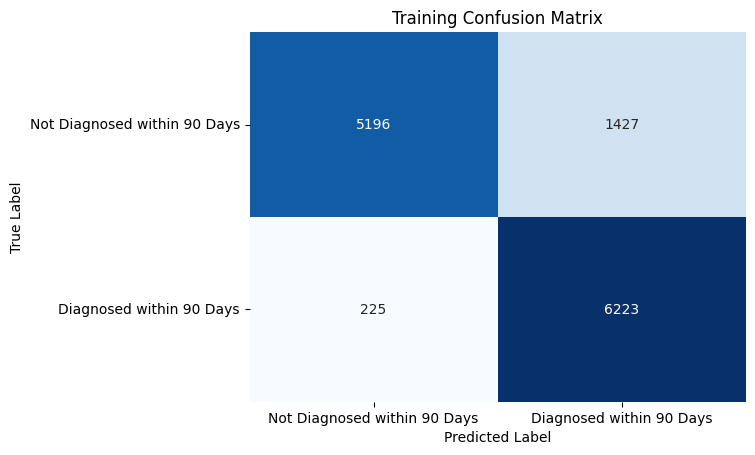

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.85      0.57      0.68       970
    Diagnosed within 90 Days       0.78      0.94      0.85      1612

                    accuracy                           0.80      2582
                   macro avg       0.82      0.75      0.77      2582
                weighted avg       0.81      0.80      0.79      2582



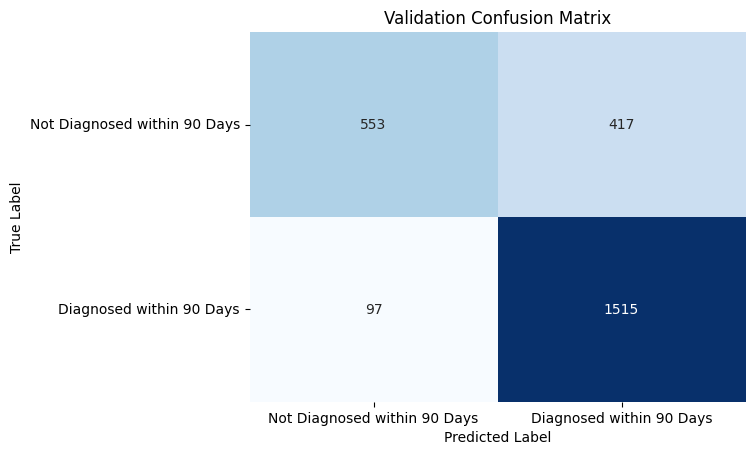


 ROC Curve


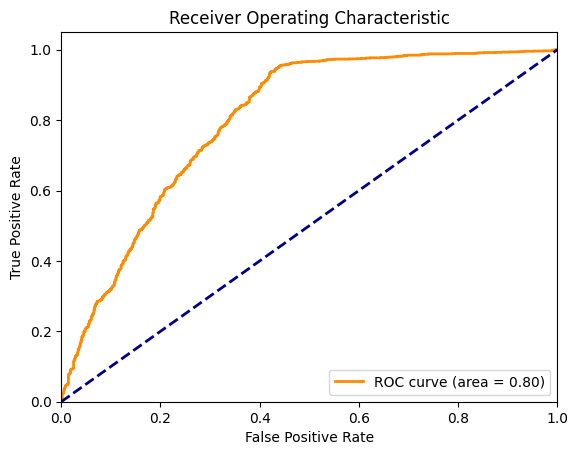

In [ ]:

class ModelBuilder:
    def __init__(self):
        self.ensemble_model = None

    def setup_ensemble_model(self, rf_params, gbc_params, et_params, lgb_params, xgb_params, cat_params):
      rf = RandomForestClassifier(**rf_params, random_state=42)
      gbc = GradientBoostingClassifier(**gbc_params, random_state=42)
      et = ExtraTreesClassifier(**et_params, random_state=42)
      lgb = LGBMClassifier(**lgb_params, random_state=42)
      xgb = XGBClassifier(**xgb_params, random_state=42)
      cat = CatBoostClassifier(**cat_params, random_state=42)
      self.ensemble_model = VotingClassifier(estimators=[
            ('rf', rf), ('gbc', gbc), ('et', et),('lgb', lgb),('xgb', xgb), ('cat', cat)], voting='soft')

      ensemble_model = VotingClassifier(estimators=[('rf', rf), ('gbc', gbc), ('et', et)], voting='soft')
      self.ensemble_model = ensemble_model

    def train_with_best_params(self, best_params, X_train, y_train):
        rf_params = {k.replace('rf__', ''): v for k, v in best_params.items() if 'rf__' in k}
        gbc_params = {k.replace('gbc__', ''): v for k, v in best_params.items() if 'gbc__' in k}
        et_params = {k.replace('et__', ''): v for k, v in best_params.items() if 'et__' in k}
        lgb_params = {k.replace('lgb__', ''): v for k, v in best_params.items() if 'lgb__' in k}
        xgb_params = {k.replace('xgb__', ''): v for k, v in best_params.items() if 'xgb__' in k}
        cat_params = {k.replace('cat__', ''): v for k, v in best_params.items() if 'cat__' in k}
        self.setup_ensemble_model(rf_params, gbc_params, et_params, lgb_params, xgb_params, cat_params)
        self.ensemble_model.fit(X_train, y_train)
        return self.ensemble_model

    def objective(self, trial, X_train, y_train, X_val, y_val):
        rf_params = {
            'n_estimators': trial.suggest_int('rf__n_estimators', 100, 800),
            'max_depth': trial.suggest_int('rf__max_depth', 2, 10),
        }
        gbc_params = {
            'n_estimators': trial.suggest_int('gbc__n_estimators', 100, 800),
            'learning_rate': trial.suggest_float('gbc__learning_rate', 0.01, 1.0),
        }
        et_params = {
            'n_estimators': trial.suggest_int('et__n_estimators', 100, 800),
            'max_depth': trial.suggest_int('et__max_depth', 2, 10),
        }
        lgb_params = {
            'n_estimators': trial.suggest_int('lgb__n_estimators', 100, 800),
            'learning_rate': trial.suggest_float('lgb__learning_rate', 0.01, 1.0),
            'max_depth': trial.suggest_int('lgb__max_depth', 2, 10),
        }
        xgb_params = {
          'n_estimators': trial.suggest_int('xgb__n_estimators', 100, 800),
          'learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 1.0),
          'max_depth': trial.suggest_int('xgb__max_depth', 2, 10),
          'min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
          'subsample': trial.suggest_float('xgb__subsample', 0.5, 1.0),
          'colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.5, 1.0),
        }
        cat_params = {
            'iterations': trial.suggest_int('cat__iterations', 100, 800),
            'learning_rate': trial.suggest_float('cat__learning_rate', 0.01, 1.0),
            'depth': trial.suggest_int('cat__depth', 2, 10),
            'l2_leaf_reg': trial.suggest_int('cat__l2_leaf_reg', 1, 10),
        }
        self.setup_ensemble_model(rf_params, gbc_params, et_params,lgb_params, xgb_params, cat_params)
        self.ensemble_model.fit(X_train, y_train)
        preds = self.ensemble_model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, preds)

    def generate_submission(self, X_val, y_val, val_patient_id, original_val_df, result_path):
      if self.ensemble_model is None:
        raise ValueError("Model has not been built yet.")

      val_yhat_probs_sub = self.ensemble_model.predict_proba(X_val)
      val_yhat_probs = self.ensemble_model.predict(X_val)



      submission = pd.DataFrame({
        'patient_id': val_patient_id,
        'DiagPeriodL90D_actual': y_val,
        'prediction': val_yhat_probs,
        'prediction_probability': val_yhat_probs_sub[:, 1],
        'breast_cancer_diagnosis_code': original_val_df['breast_cancer_diagnosis_code'],
        'patient_age': original_val_df['patient_age'],
        'metastatic_cancer_diagnosis_code': original_val_df['metastatic_cancer_diagnosis_code'],
        'patient_race': original_val_df['patient_race'],
        'patient_zip3': original_val_df['patient_zip3'],
        'patient_state': original_val_df['patient_state'],
        'payer_type': original_val_df['payer_type'],
        'income_household_25_to_35': original_val_df['income_household_25_to_35'],
        'rent_burden': original_val_df['rent_burden'],
        'income_household_under_5': original_val_df['income_household_under_5']
      })

      original_val_df.reset_index(drop=True, inplace=True)

      submission.to_csv(result_path + 'RF_feb_25_optuna.csv', index=False)

      errors_only = submission[submission['DiagPeriodL90D_actual'] != submission['prediction']]

      errors_only.to_csv(result_path + 'RF_feb_25_errors_optuna.csv', index=False)

      return submission, errors_only

    def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

    def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

    def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
        report = classification_report(y_val, val_yhat_probs, target_names=classes)
        return report

    def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
        val_cm = confusion_matrix(y_val, val_yhat_probs)
        ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Validation Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
      """
      Plot the Receiver Operating Characteristic (ROC) curve.

      Args:
      y_true (array-like): True binary labels.
      y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

      Returns:
      None (displays the ROC curve plot).
      """
      fpr, tpr, _ = roc_curve(y_true, y_scores)
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()



model_trainer = ModelBuilder()
def objective_wrapper(trial):
    return model_trainer.objective(trial, X_train, y_train, X_val, y_val)


study = optuna.create_study(direction='maximize')
study.optimize(objective_wrapper, n_trials=100)

best_params = study.best_params
trained_model = model_trainer.train_with_best_params(best_params, X_train, y_train)



result_path = '/content/drive/MyDrive/HS/prediction/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, val_df_selected, result_path)


train_yhat_probs = trained_model.predict(X_train)
val_yhat_probs = trained_model.predict(X_val)
val_yhat_probs_sub = trained_model.predict_proba(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
y_true = y_val
y_scores = val_yhat_probs
y_scores_sub = val_yhat_probs_sub
y_scores_pos_class = val_yhat_probs_sub[:, 1]
model_trainer.plot_roc_curve(y_true, y_scores_pos_class)


In [ ]:
from joblib import dump
from joblib import load

result_path = '/content/drive/MyDrive/HS/prediction/'

dump(trained_model, result_path + 'ensemble_optuna.joblib')

trained_model = load(result_path + 'ensemble_optuna.joblib')


def generate_test_submission(trained_model, X_test, test_patient_id, result_path):
      if trained_model is None:
        raise ValueError("Model has not been built yet.")

      test_yhat_probs_sub = trained_model.predict_proba(X_test)
      test_yhat_probs = trained_model.predict(X_test)
      print(test_yhat_probs)


      submission = pd.DataFrame({
        'patient_id': test_patient_id,
        'prediction_probability': test_yhat_probs_sub[:, 1]
      })

      #original_test_df.reset_index(drop=True, inplace=True)

      submission.to_csv(result_path + 'RF_feb_25_optuna_test.csv', index=False)

      return submission

result_path = '/content/drive/MyDrive/HS/prediction/'
generate_test_submission(trained_model, X_test, test_patient_id, result_path)


[1 1 1 ... 1 0 1]


,patient_id,prediction_probability
0,573710.0,0.644706
1,593679.0,0.544961
2,184532.0,0.663997
3,447383.0,0.621904
4,687972.0,0.499363
...,...,...
5787,977076.0,0.538305
5788,922960.0,0.466432
5789,759690.0,0.677252
5790,911717.0,0.245363


In [ ]:
import optuna.visualization as ov
# Visualize the optimization history
ov.plot_optimization_history(study)

In [ ]:
# Visualize the parameter importance
ov.plot_param_importances(study)